<a href="https://colab.research.google.com/github/ag-wnl/kaggle_models/blob/main/brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

To handle file in google colab

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
main_path = '/content/drive/MyDrive/brain_tumor_dataset'
os.listdir(main_path)

['no', 'yes']

Initialising model

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(device)

cuda


In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transoforms = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [6]:
dataset = datasets.ImageFolder(main_path, train_transforms)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

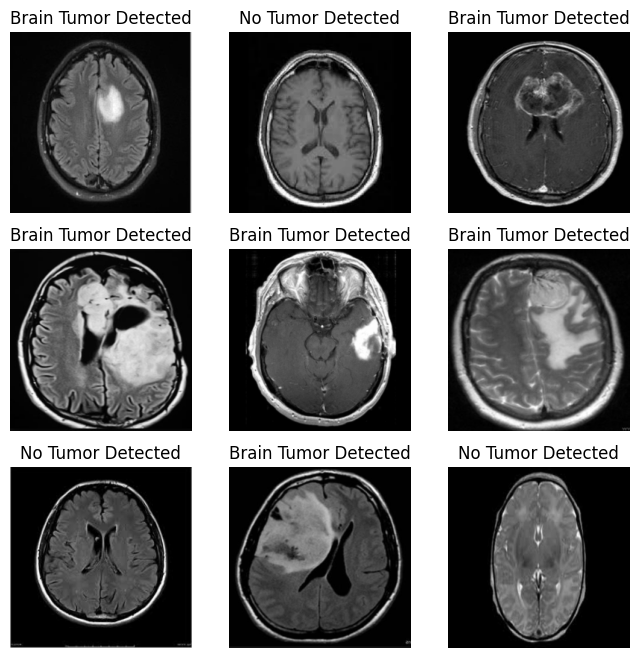

In [7]:
dataiter = iter(dataloader)
X,Y = next(dataiter)
classes = {0: 'No Tumor Detected', 1: 'Brain Tumor Detected'}
fig,axes = plt.subplots(3,3,figsize=(8,8))

for i in range(3):
    for j in range(3):
        plt.sca(axes[i,j])
        idx = np.random.randint(0,31)
        image = np.moveaxis(X[idx].numpy(),0,2)
        plt.title(classes[Y[idx].item()])
        plt.imshow(image,cmap='gray')
        plt.axis('off');

Defining CNN Architecture

In [8]:
def convBlock(in_size, out_size):
    return nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(out_size),
            nn.Conv2d(out_size, out_size, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_size),
            nn.MaxPool2d(2),
    )

In [9]:
class BrainCancerClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = convBlock(1, 32)
        self.conv2 = convBlock(32, 64)
        self.conv3 = convBlock(64, 128)
        self.conv4 = convBlock(128, 256)
        self.conv5 = convBlock(256, 512)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512, 256)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [44]:
model = BrainCancerClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [45]:
num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    accuracy = total_correct / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/20], Loss: 0.7792, Accuracy: 0.6126
Epoch [2/20], Loss: 0.5530, Accuracy: 0.7352
Epoch [3/20], Loss: 0.5441, Accuracy: 0.7747
Epoch [4/20], Loss: 0.4934, Accuracy: 0.7984
Epoch [5/20], Loss: 0.4832, Accuracy: 0.7866
Epoch [6/20], Loss: 0.4629, Accuracy: 0.8142
Epoch [7/20], Loss: 0.4417, Accuracy: 0.8379
Epoch [8/20], Loss: 0.4254, Accuracy: 0.8261
Epoch [9/20], Loss: 0.4070, Accuracy: 0.8300
Epoch [10/20], Loss: 0.3515, Accuracy: 0.8577
Epoch [11/20], Loss: 0.4554, Accuracy: 0.8063
Epoch [12/20], Loss: 0.3728, Accuracy: 0.8379
Epoch [13/20], Loss: 0.3908, Accuracy: 0.8419
Epoch [14/20], Loss: 0.3805, Accuracy: 0.8538
Epoch [15/20], Loss: 0.3139, Accuracy: 0.8814
Epoch [16/20], Loss: 0.3117, Accuracy: 0.8854
Epoch [17/20], Loss: 0.3255, Accuracy: 0.8538
Epoch [18/20], Loss: 0.2523, Accuracy: 0.9051
Epoch [19/20], Loss: 0.2533, Accuracy: 0.9012
Epoch [20/20], Loss: 0.2170, Accuracy: 0.9170


In [12]:
torch.save(model.state_dict(), "brain_tumor_classifier.pth")

In [36]:
from torchsummary import summary
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
            Conv2d-4         [-1, 32, 224, 224]           9,248
              ReLU-5         [-1, 32, 224, 224]               0
       BatchNorm2d-6         [-1, 32, 224, 224]              64
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
              ReLU-9         [-1, 64, 112, 112]               0
      BatchNorm2d-10         [-1, 64, 112, 112]             128
           Conv2d-11         [-1, 64, 112, 112]          36,928
             ReLU-12         [-1, 64, 112, 112]               0
      BatchNorm2d-13         [-1, 64, 112, 112]             128
        MaxPool2d-14           [-1, 64,